# Fauna Finder

# 1. Setting up and getting the data

1.1 Installing Dependent libraries and setup

In [1]:
!pip install labelme tensorflow opencv-python matplotlib albumentations

Defaulting to user installation because normal site-packages is not writeable


1.2 Importing libraries to collect images using opencv

In [2]:
import os
import time
import uuid #uniform unique identifier
import cv2

In [3]:
IMAGES_PATH = os.path.join('data','images')
number_images = 15

In [ ]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1.3 Annotate Images with LabelMe

In [41]:
!labelme

# 2. Reviewing the Dataset and Build Image Loading Function

### 2.1 Importing Tensorflow and Dependencies

In [4]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Load Image into TF Data Pipeline

In [28]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [29]:
images.as_numpy_iterator().next()

b'data\\images\\b78634be-adc9-11ed-889d-60189536bc9e.jpg'

In [22]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
images = images.map(load_image)

In [32]:
images.as_numpy_iterator().next()

array([[[208, 194, 207],
        [208, 194, 207],
        [209, 193, 204],
        ...,
        [ 11,  15,  14],
        [ 22,  28,  28],
        [ 24,  30,  30]],

       [[207, 193, 206],
        [207, 193, 206],
        [208, 192, 203],
        ...,
        [ 12,  16,  15],
        [ 19,  23,  22],
        [ 24,  28,  27]],

       [[208, 192, 203],
        [208, 192, 203],
        [208, 192, 203],
        ...,
        [ 15,  17,  14],
        [ 16,  18,  15],
        [ 21,  23,  20]],

       ...,

       [[118,  89,  55],
        [118,  90,  53],
        [110,  80,  42],
        ...,
        [ 28,  26,  31],
        [ 27,  25,  30],
        [ 27,  25,  28]],

       [[123,  93,  59],
        [127,  97,  61],
        [129,  97,  58],
        ...,
        [ 26,  25,  30],
        [ 25,  24,  29],
        [ 25,  24,  29]],

       [[137, 107,  73],
        [136, 106,  70],
        [141, 109,  70],
        ...,
        [ 24,  25,  30],
        [ 24,  25,  29],
        [ 25,  26,  30]]

In [33]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

### 2.3 View Raw Images with Matplotlib

In [ ]:
image_generator = images.batch(4).as_numpy_iterator()

In [37]:
plot_images = image_generator.next()

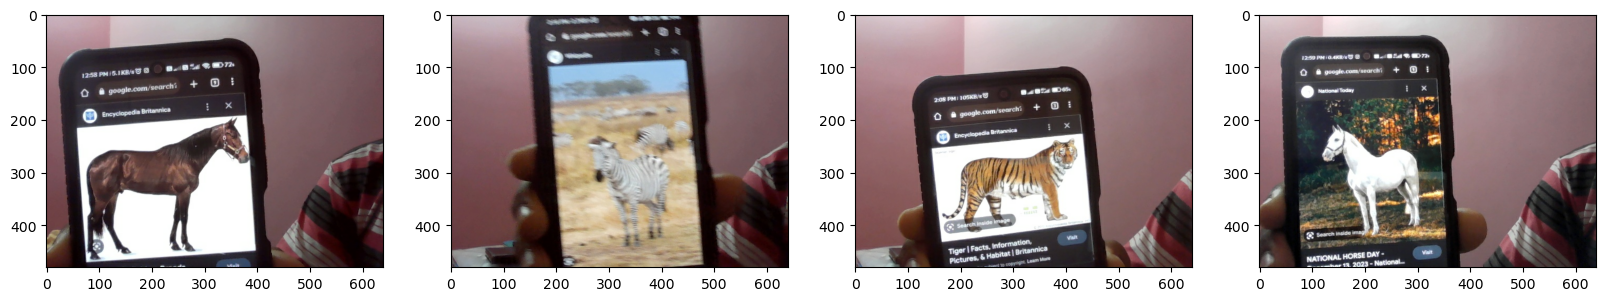

In [38]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

## 3. Partition Unaugmented Data

### 3.1 Splitting data into Train, Test and Valuation set - Manually

In [44]:
228*.7 #161 to train

159.6

In [45]:
228*.15 #35 to test and 34 to val

34.199999999999996

### 3.2 Moving the matching labels:

In [46]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)

## 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline


In [5]:
import albumentations as alb

In [6]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                         bbox_params=alb.BboxParams(format='albumentations', 
                         label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON


In [7]:
img = cv2.imread(os.path.join('data','train', 'images','1f7c90f0-add5-11ed-9f94-60189536bc9e.jpg'))

In [8]:
with open(os.path.join('data', 'train', 'labels', '1f7c90f0-add5-11ed-9f94-60189536bc9e.json'), 'r') as f:
    label = json.load(f)

In [9]:
label['shapes']

[{'label': 'rhinoceros',
  'points': [[368.46153846153845, 300.51282051282055],
   [230.5128205128205, 425.6410256410257]],
  'group_id': None,
  'shape_type': 'rectangle',
  'flags': {}}]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [10]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [11]:
coords

[368.46153846153845, 300.51282051282055, 230.5128205128205, 425.6410256410257]

In [12]:
coords = list(np.divide(coords, [720,480,360,480]))

In [13]:
coords

[0.5117521367521367,
 0.6260683760683762,
 0.6403133903133903,
 0.8867521367521368]

### 4.4 Apply Augmentations and View Results

In [14]:
augmented = augmentor(image=img, bboxes=[coords] , class_labels=['rhinoceros'])

In [15]:
augmented['bboxes'][0][2:]

(0.30328584995251673, 0.3855270655270654)

In [16]:
augmented['bboxes']

[(0.12044317822095596,
  0.10746438746438736,
  0.30328584995251673,
  0.3855270655270654)]

In [17]:
augmented['image']

array([[[ 72,  62,  58],
        [ 72,  64,  61],
        [ 72,  66,  63],
        ...,
        [208, 204, 196],
        [203, 201, 193],
        [203, 200, 195]],

       [[ 71,  61,  57],
        [ 72,  64,  61],
        [ 72,  66,  63],
        ...,
        [209, 202, 195],
        [210, 207, 198],
        [206, 202, 194]],

       [[ 74,  64,  61],
        [ 73,  64,  64],
        [ 73,  67,  66],
        ...,
        [210, 203, 196],
        [211, 206, 196],
        [211, 204, 197]],

       ...,

       [[226, 222, 234],
        [226, 222, 234],
        [226, 222, 234],
        ...,
        [241, 228, 250],
        [239, 227, 249],
        [237, 227, 249]],

       [[227, 224, 234],
        [227, 224, 234],
        [227, 224, 234],
        ...,
        [241, 228, 248],
        [240, 229, 248],
        [240, 229, 248]],

       [[228, 225, 235],
        [228, 225, 235],
        [228, 225, 235],
        ...,
        [245, 230, 250],
        [240, 229, 248],
        [241, 230, 249]]

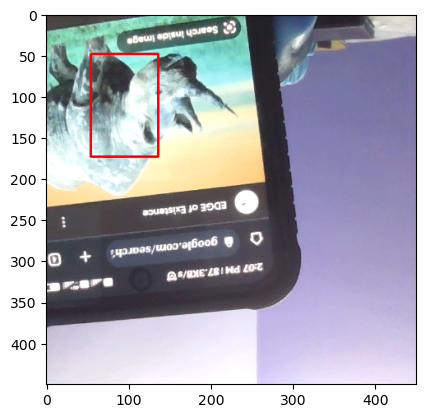

In [18]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

## 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [19]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [1700,480,500,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)
            

image must be numpy array type
Expected x_max for bbox [0.20346907993966817, 0.3301282051282051, 1.1307692307692307, 0.75, 'face'] to be in the range [0.0, 1.0], got 1.1307692307692307.
y_max is less than or equal to y_min for bbox [0.21161387631975867, 0.07905982905982906, 0.4815384615384615, 0.006410256410256411, 'face'].
x_max is less than or equal to x_min for bbox [0.19019607843137254, 0.5288461538461539, 0.1676923076923077, 0.875, 'face'].
x_max is less than or equal to x_min for bbox [0.17541478129713423, 0.2863247863247863, 0.1676923076923077, 0.7297008547008548, 'face'].
x_max is less than or equal to x_min for bbox [0.14947209653092006, 0.6933760683760684, 0.11230769230769229, 0.9754273504273505, 'face'].
x_max is less than or equal to x_min for bbox [0.23755656108597287, 0.3888888888888889, 0.23641025641025643, 0.8803418803418804, 'face'].
x_max is less than or equal to x_min for bbox [0.16365007541478127, 0.452991452991453, 0.16358974358974362, 0.8707264957264957, 'face'].


### 5.2 Load Augmented Images to Tensorflow Dataset

In [23]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [24]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [25]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [26]:
train_images.as_numpy_iterator().next()

array([[[0.8030025 , 0.7231005 , 0.7583946 ],
        [0.8081495 , 0.71795344, 0.7565564 ],
        [0.8181372 , 0.71617645, 0.7593137 ],
        ...,
        [0.64295346, 0.5606005 , 0.58020836],
        [0.6343137 , 0.55196077, 0.5715686 ],
        [0.6318015 , 0.5396446 , 0.56170344]],

       [[0.7934436 , 0.7114583 , 0.7563726 ],
        [0.7921569 , 0.69846815, 0.7481618 ],
        [0.8025122 , 0.7015319 , 0.7456495 ],
        ...,
        [0.64215684, 0.5598039 , 0.57941175],
        [0.6279412 , 0.54607844, 0.56421566],
        [0.6297181 , 0.5439338 , 0.5615809 ]],

       [[0.7872549 , 0.69558823, 0.7392157 ],
        [0.7886642 , 0.6945466 , 0.74552697],
        [0.7886642 , 0.6945466 , 0.74552697],
        ...,
        [0.6387868 , 0.54859066, 0.5721201 ],
        [0.63094366, 0.5446691 , 0.5564338 ],
        [0.62732846, 0.54154414, 0.55919117]],

       ...,

       [[0.1971201 , 0.09871323, 0.078125  ],
        [0.19007353, 0.08419117, 0.04105392],
        [0.18492647, 0

## 6. Prepare Labels

### 6.1 Build Label Loading Function

In [27]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [28]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [29]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [30]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [31]:
test_labels.as_numpy_iterator().next()

(array([0], dtype=uint8), array([0., 0., 0., 0.], dtype=float16))

## 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [32]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(9180, 9180, 1680, 1680, 1740, 1740)

### 7.2 Create Final Datasets (Images/Labels)

In [33]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(12000)
train = train.batch(8)
train = train.prefetch(4)

In [34]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1800)
test = test.batch(8)
test = test.prefetch(4)

In [35]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(2000)
val = val.batch(8)
val = val.prefetch(4)

In [36]:
train.as_numpy_iterator().next()[0]

array([[[[0.28811276, 0.24889706, 0.2425245 ],
         [0.22579657, 0.18560049, 0.18572304],
         [0.22506127, 0.1651348 , 0.17377451],
         ...,
         [0.99963236, 0.91875   , 0.78719366],
         [0.9943015 , 0.89295346, 0.76029414],
         [0.99031866, 0.8824142 , 0.7579657 ]],

        [[0.3211397 , 0.28229168, 0.28504902],
         [0.31887254, 0.27867648, 0.28210783],
         [0.30563724, 0.23259804, 0.23995098],
         ...,
         [0.934375  , 0.8333946 , 0.68878675],
         [0.98376226, 0.88327205, 0.75392157],
         [0.933701  , 0.8292892 , 0.7153799 ]],

        [[0.33204657, 0.28970587, 0.27408087],
         [0.32634804, 0.29797795, 0.27720588],
         [0.32947305, 0.28241423, 0.28198528],
         ...,
         [0.8338848 , 0.77052695, 0.6657475 ],
         [0.860723  , 0.8086397 , 0.73670346],
         [0.81648284, 0.77481616, 0.73223037]],

        ...,

        [[0.6911765 , 0.577451  , 0.59705883],
         [0.6940564 , 0.58817405, 0.6077819 ]

### 7.3 View Images and Annotations

In [37]:
data_samples = train.as_numpy_iterator()

In [46]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


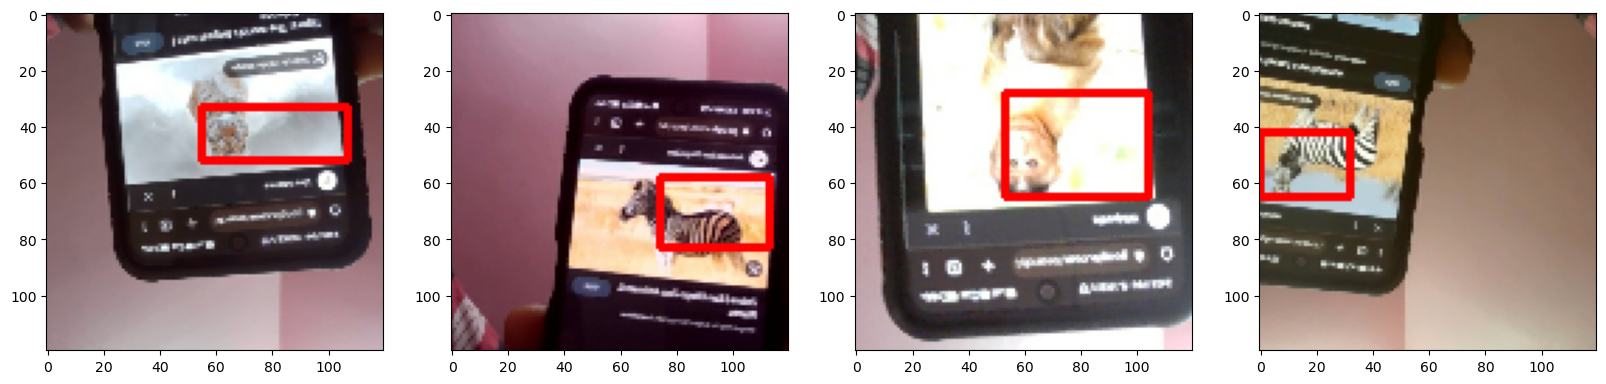

In [47]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

## 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [48]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from keras.applications import VGG16 #model for fasterrcnn

### 8.2 Building faster_r_cnn

In [49]:
frcnn = VGG16(include_top=False)

In [50]:
frcnn.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Building Neural Network


In [51]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    frcnn = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(frcnn)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(frcnn)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    animaltracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return animaltracker

### 8.4 Testing the Neural Network

In [52]:
animaltracker = build_model()

In [53]:
animaltracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_3[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [54]:
X, y = train.as_numpy_iterator().next()

In [55]:
X.shape

(8, 120, 120, 3)

In [56]:
classes, coords = animaltracker.predict(X)

1/1 [==============================] - 0s 356ms/step


In [57]:
classes, coords

(array([[0.56254447],
        [0.40239945],
        [0.4252777 ],
        [0.4518441 ],
        [0.4151266 ],
        [0.38534173],
        [0.40335348],
        [0.4474618 ]], dtype=float32),
 array([[0.6134405 , 0.5548183 , 0.3948886 , 0.57979935],
        [0.59594613, 0.57615477, 0.4140981 , 0.49487692],
        [0.6381155 , 0.5478487 , 0.434569  , 0.5027503 ],
        [0.63350016, 0.6354552 , 0.34765357, 0.48551413],
        [0.63935983, 0.5817064 , 0.48310536, 0.5916233 ],
        [0.63160443, 0.54639584, 0.3301849 , 0.48619115],
        [0.6350915 , 0.61613464, 0.39885125, 0.6031103 ],
        [0.5775166 , 0.60888326, 0.3401342 , 0.5925153 ]], dtype=float32))

## 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR


In [58]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [59]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)


### 9.2 Create Localization Loss and Classification Loss

In [60]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [61]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [62]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.8998413>

In [63]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.83499086>

In [64]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=5.8998413>

## 10. Train Neural Network

### 10.1 Create Custom Model Class

In [65]:
class AnimalTracker(Model): 
    def __init__(self, faunatracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = faunatracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [66]:
model = AnimalTracker(animaltracker)

In [67]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [68]:
logdir='logs'

In [69]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [70]:
hist = model.fit(train.take(80), epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10
80/80 [==============================] - 130s 2s/step - total_loss: 1.6139 - class_loss: 0.2518 - regress_loss: 1.4880 - val_total_loss: 0.4495 - val_class_loss: 0.0522 - val_regress_loss: 0.4234
Epoch 2/10
80/80 [==============================] - 139s 2s/step - total_loss: 1.2211 - class_loss: 0.2256 - regress_loss: 1.1083 - val_total_loss: 0.5238 - val_class_loss: 0.3702 - val_regress_loss: 0.3387
Epoch 3/10
80/80 [==============================] - 183s 2s/step - total_loss: 1.1161 - class_loss: 0.1960 - regress_loss: 1.0181 - val_total_loss: 1.0189 - val_class_loss: 1.0086 - val_regress_loss: 0.5146
Epoch 4/10
80/80 [==============================] - 222s 3s/step - total_loss: 0.9463 - class_loss: 0.1679 - regress_loss: 0.8624 - val_total_loss: 0.3939 - val_class_loss: 0.0057 - val_regress_loss: 0.3911
Epoch 5/10
80/80 [==============================] - 212s 3s/step - total_loss: 0.8983 - class_loss: 0.1526 - regress_loss: 0.8221 - val_total_loss: 0.2337 - val_class_loss:

### 10.3 Plot Performance

In [71]:
hist.history

{'total_loss': [1.5694284439086914,
  0.4804620146751404,
  2.0356760025024414,
  0.6865568161010742,
  0.6610235571861267,
  0.6644071340560913,
  0.7383605241775513,
  1.0270771980285645,
  0.20334558188915253,
  0.3080870509147644],
 'class_loss': [0.33930695056915283,
  0.03268670290708542,
  0.6508098244667053,
  0.10009674727916718,
  0.017758997157216072,
  0.23529869318008423,
  0.04894952103495598,
  0.226046621799469,
  0.05383787676692009,
  0.013173596933484077],
 'regress_loss': [1.3997750282287598,
  0.4641186594963074,
  1.7102711200714111,
  0.6365084648132324,
  0.6521440744400024,
  0.5467578172683716,
  0.7138857841491699,
  0.9140539169311523,
  0.17642664909362793,
  0.30150026082992554],
 'val_total_loss': [0.44945862889289856,
  0.5238007307052612,
  1.0188766717910767,
  0.3939462900161743,
  0.23369674384593964,
  0.7731003165245056,
  0.40075698494911194,
  0.3283974826335907,
  1.2237664461135864,
  0.7649394273757935],
 'val_class_loss': [0.05220611020922661

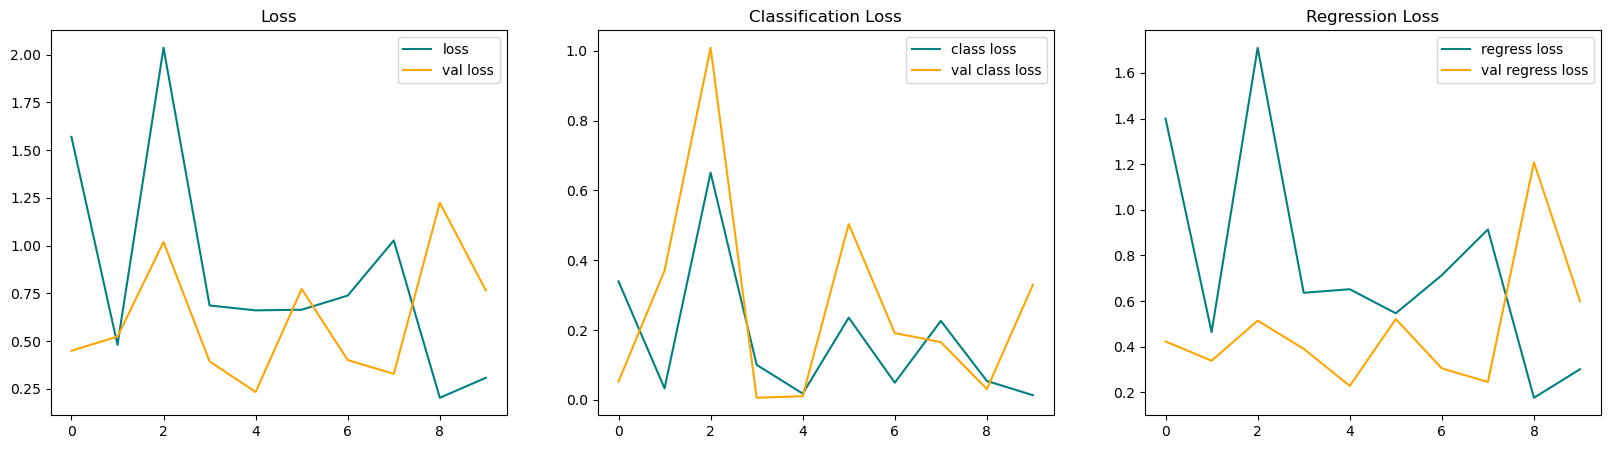

In [72]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

## 11. Making Prediction and Detection

### 11.1 Make Predictions on Test Set

In [73]:
test_data = test.as_numpy_iterator()

In [125]:
test_sample = test_data.next()

In [126]:
yhat = animaltracker.predict(test_sample[0])

1/1 [==============================] - 0s 168ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


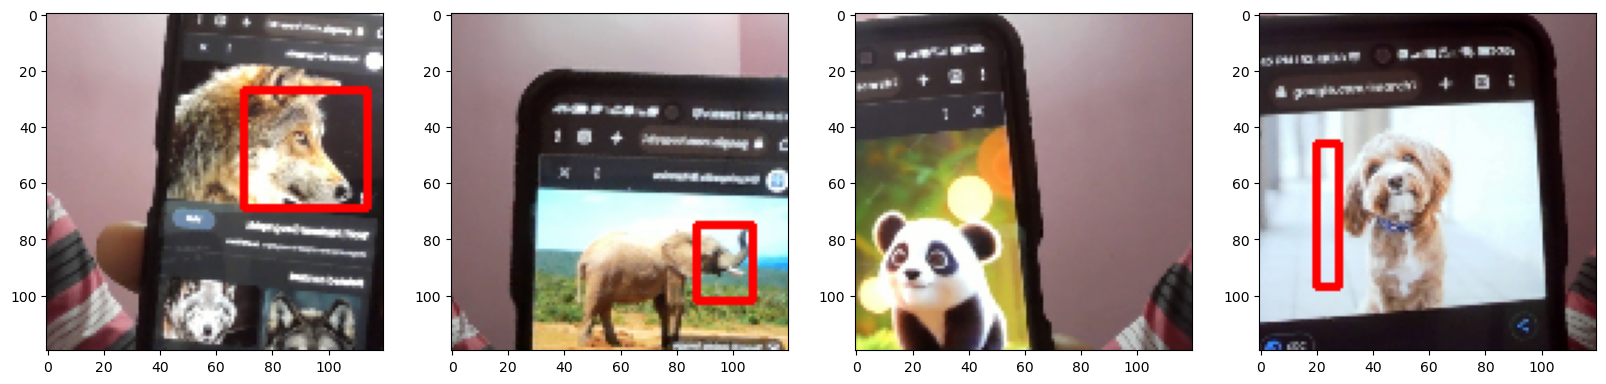

In [127]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)


### 11.2 Saving the Model

In [128]:
from tensorflow.keras.models import load_model

In [129]:
animaltracker.save('animaltracker.h5')

In [130]:
animaltracker = load_model('animaltracker.h5')

### 11.3 Real Time Detection

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = animaltracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame,'rhinoceros' , tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('Fauna Finder', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - ETA: 0s